In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [758]:
train = pd.read_csv('train2.csv')
test = pd.read_table('test2.txt',sep=',')

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [703]:
index_series = test['index']

In [704]:
train.head()

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribe
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [705]:
train.columns

Index(['index', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'subscribe'],
      dtype='object')

In [706]:
train.isnull().sum()

index        0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
subscribe    0
dtype: int64

In [707]:
train.shape

(40211, 18)

## class -> label Encoding

In [708]:
# from sklearn.preprocessing import LabelEncoder
# enclist = []
# classlist = ['job','marital','education','default','housing','loan','contact','month','subscribe','poutcome']
# for cl in classlist:
#     enc = LabelEncoder()
#     train[cl] = enc.fit_transform(train[cl])
#     enclist.append(enc)

In [709]:
# sns.pairplot(train)

## After scaling

In [710]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled_train = scaler.fit_transform(train)
# scaled_train = pd.DataFrame(scaled_train, columns=train.columns)

In [711]:
# scaled_train.head()

### subscribe => LabelEncoding

['no' 'yes']


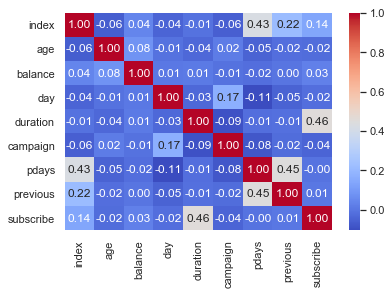

In [712]:
# subscribe label encoding

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
train['subscribe'] = enc.fit_transform(train['subscribe'])
print(enc.classes_)
g = sns.heatmap(train.corr(),annot=True,fmt='.2f',cmap='coolwarm')

## Remove Outlier

In [713]:
numerical_list = ['age','balance','duration','campaign','day','pdays','previous']

In [714]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from age, balance, duration
outliers_to_drop = detect_outliers(train, 3, numerical_list)

In [715]:
len(outliers_to_drop)

65

In [716]:
# Drop outliers
train = train.drop(outliers_to_drop, axis=0).reset_index(drop=True)

In [717]:
# joining train & test set
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [718]:
dataset.head()

,age,balance,campaign,contact,day,default,duration,education,housing,index,job,loan,marital,month,pdays,poutcome,previous,subscribe
0,58,2143,1,unknown,5,no,261,tertiary,yes,0,management,no,married,may,-1,unknown,0,0.0
1,44,29,1,unknown,5,no,151,secondary,yes,1,technician,no,single,may,-1,unknown,0,0.0
2,33,2,1,unknown,5,no,76,secondary,yes,2,entrepreneur,yes,married,may,-1,unknown,0,0.0
3,47,1506,1,unknown,5,no,92,unknown,yes,3,blue-collar,no,married,may,-1,unknown,0,0.0
4,33,1,1,unknown,5,no,198,unknown,no,4,unknown,no,single,may,-1,unknown,0,0.0


In [719]:
dataset.tail()

,age,balance,campaign,contact,day,default,duration,education,housing,index,job,loan,marital,month,pdays,poutcome,previous,subscribe
45141,51,825,3,cellular,17,no,977,tertiary,no,45206,technician,no,married,nov,-1,unknown,0,NaN
45142,71,1729,2,cellular,17,no,456,primary,no,45207,retired,no,divorced,nov,-1,unknown,0,NaN
45143,72,5715,5,cellular,17,no,1127,secondary,no,45208,retired,no,married,nov,184,success,3,NaN
45144,57,668,4,telephone,17,no,508,secondary,no,45209,blue-collar,no,married,nov,-1,unknown,0,NaN
45145,37,2971,2,cellular,17,no,361,secondary,no,45210,entrepreneur,no,married,nov,188,other,11,NaN


### numerical data visualization

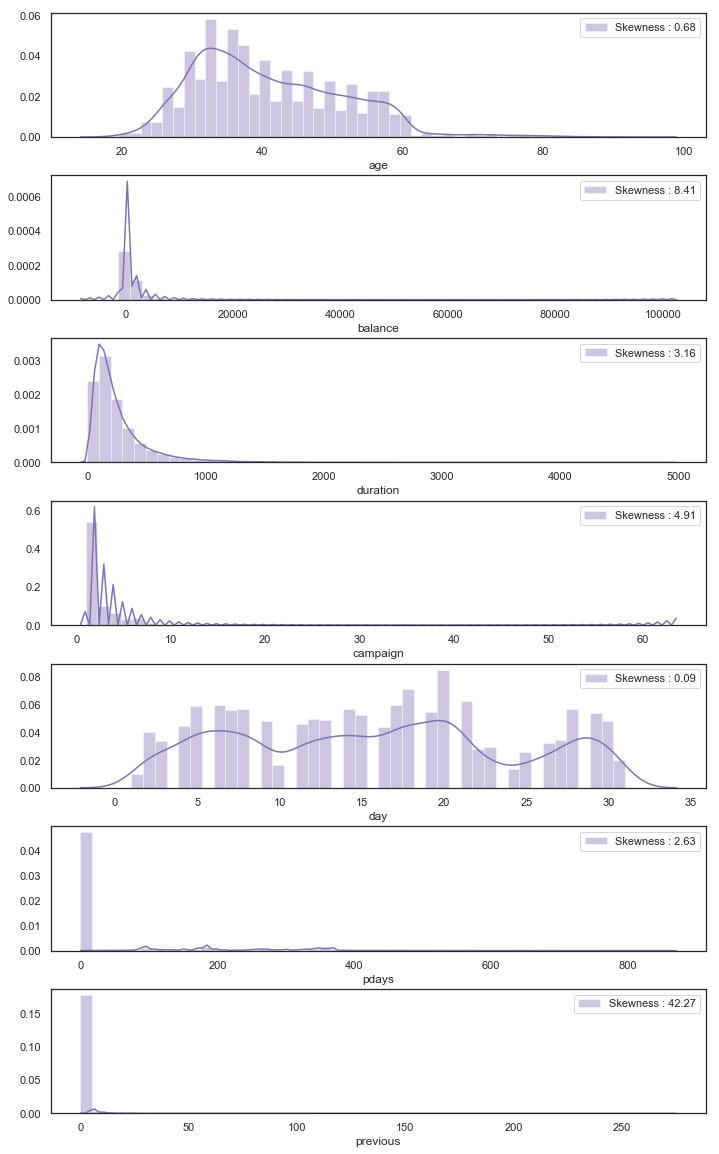

In [720]:
# check distribution of each feature
f, ax = plt.subplots(len(numerical_list),1,figsize=(10,16))
f.tight_layout()
for i, cl in enumerate(numerical_list):
    g = sns.distplot(dataset[cl], color="m", label="Skewness : %.2f"%(dataset[cl].skew()), ax=ax[i])
    g = g.legend(loc="best")

In [721]:
dataset['pdays'] = np.where(dataset['pdays']>0,1,0)
dataset['previous'] = np.where(dataset['previous']>0,1,0)

In [722]:
dataset.describe()

,age,balance,campaign,day,duration,index,pdays,previous,subscribe
count,45146.000000,45146.000000,45146.000000,45146.000000,45146.000000,45146.000000,45146.000000,45146.000000,40146.000000
mean,40.936739,1355.566052,2.762238,15.808687,257.505958,22589.312940,0.181456,0.181456,0.073606
std,10.620187,3038.852675,3.097864,8.323976,256.596594,13052.916007,0.385400,0.385400,0.261132
min,18.000000,-8019.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,1.000000,8.000000,103.000000,11286.250000,0.000000,0.000000,0.000000
50%,39.000000,447.000000,2.000000,16.000000,180.000000,22572.500000,0.000000,0.000000,0.000000
75%,48.000000,1417.000000,3.000000,21.000000,318.000000,33884.750000,0.000000,0.000000,0.000000
max,95.000000,102127.000000,63.000000,31.000000,4918.000000,45210.000000,1.000000,1.000000,1.000000


C:\Users\user\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


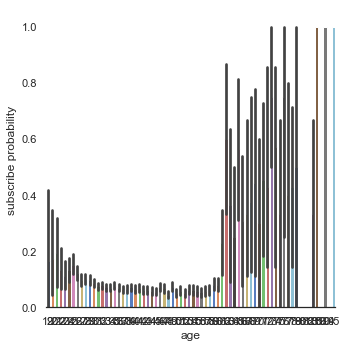

In [723]:
g = sns.factorplot(x='age', y='subscribe', data=train, kind='bar',palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('subscribe probability')

C:\Users\user\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


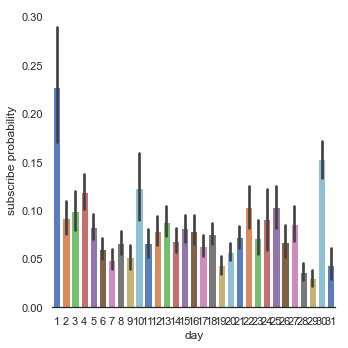

In [724]:
g = sns.factorplot(x='day', y='subscribe', data=train, kind='bar',palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('subscribe probability')

C:\Users\user\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


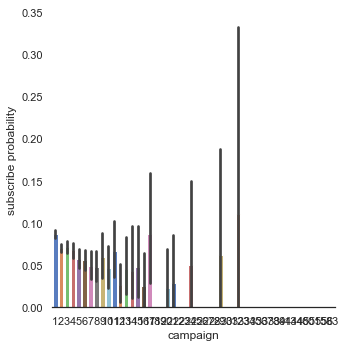

In [725]:
g = sns.factorplot(x='campaign', y='subscribe', data=train, kind='bar',palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('subscribe probability')

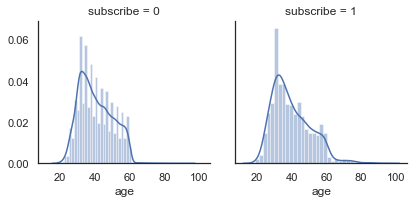

In [726]:
g = sns.FacetGrid(train, col='subscribe')
g = g.map(sns.distplot, "age")

### Flatten skewed data

In [727]:
skewedlist = ['balance','duration','campaign','previous']

In [728]:
for cl in skewedlist:
    dataset[cl] = dataset[cl].map(lambda x : np.log(x) if x>0 else x)
    dataset[cl] = dataset[cl].map(lambda x : -np.log(-x) if x<0 else x)

In [729]:
# After scaling

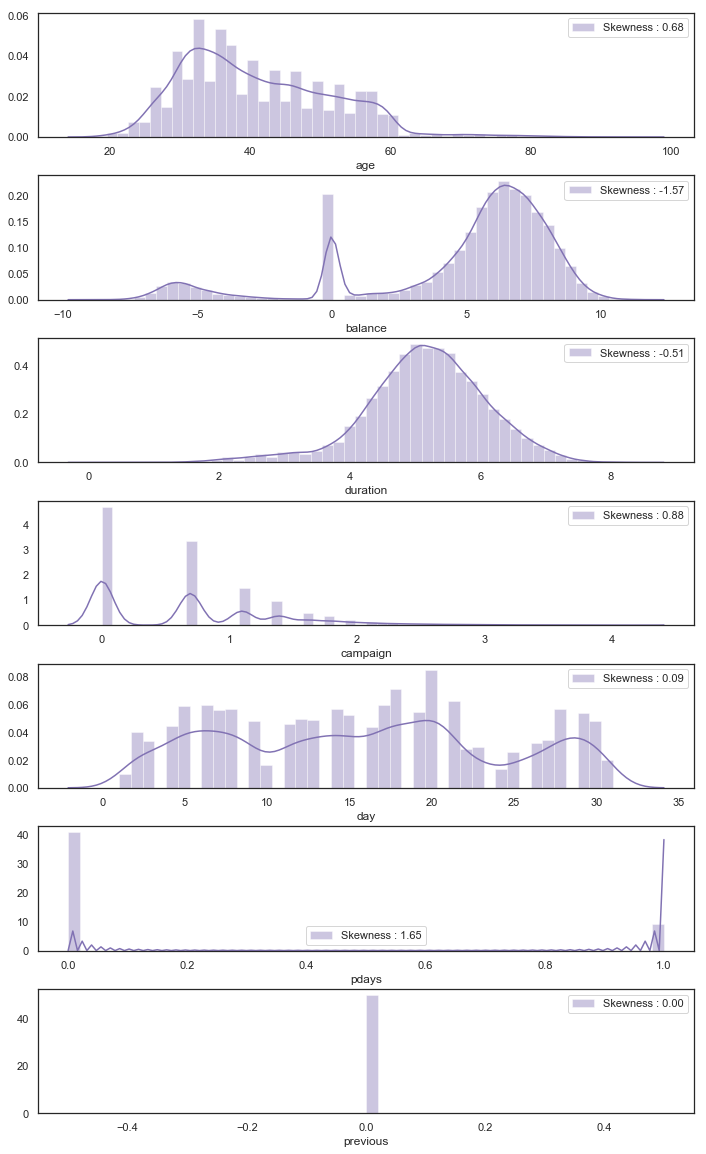

In [730]:
# check distribution of each feature
f, ax = plt.subplots(len(numerical_list),1,figsize=(10,16))
f.tight_layout()
for i, cl in enumerate(numerical_list):
    g = sns.distplot(dataset[cl], color="m", label="Skewness : %.2f"%(dataset[cl].skew()), ax=ax[i])
    g = g.legend(loc="best")

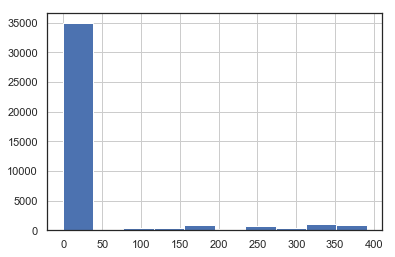

In [731]:
train.pdays.sort_values().hist()

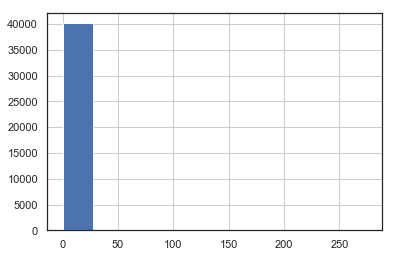

In [732]:
train.previous.sort_values().hist()

In [733]:
# 너무 편향된 두 feature 날림

dataset.drop(columns=['pdays','previous'],inplace=True)

### Categorical Values

In [734]:
cate_list = ['job','marital','education','default','housing','loan','contact','month','poutcome']

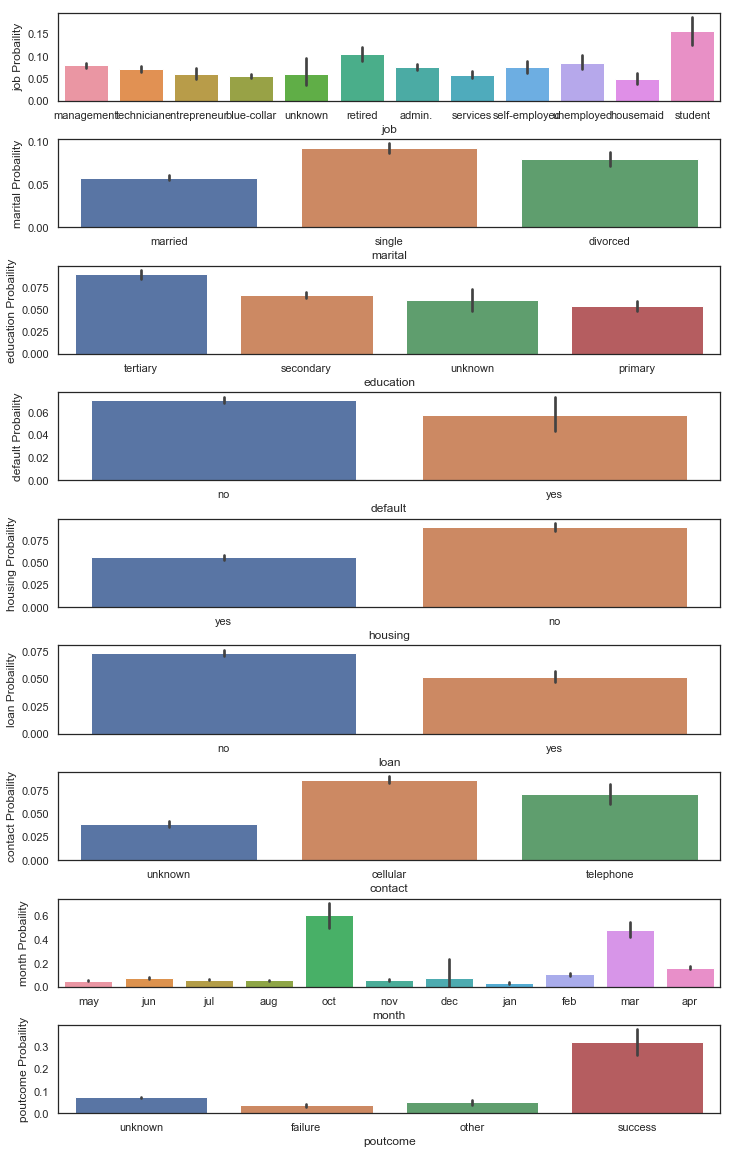

In [438]:
# check distribution of each feature
f, ax = plt.subplots(len(cate_list),1,figsize=(10,16))
f.tight_layout()
for i, cl in enumerate(cate_list):
    g = sns.barplot(x=cl,y='subscribe', data=train, ax=ax[i])
    g = g.set_ylabel(cl+' Probaility')

In [444]:
dataset.poutcome.unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

### Feature enginnering

In [735]:
# make categorical data as categorical
for cl in cate_list:
    dataset[cl] = dataset[cl].astype('category')

In [736]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45146 entries, 0 to 45145
Data columns (total 16 columns):
age          45146 non-null int64
balance      45146 non-null float64
campaign     45146 non-null float64
contact      45146 non-null category
day          45146 non-null int64
default      45146 non-null category
duration     45146 non-null float64
education    45146 non-null category
housing      45146 non-null category
index        45146 non-null int64
job          45146 non-null category
loan         45146 non-null category
marital      45146 non-null category
month        45146 non-null category
poutcome     45146 non-null category
subscribe    40146 non-null float64
dtypes: category(9), float64(4), int64(3)
memory usage: 2.8 MB


In [737]:
dataset['subscribe'] = dataset['subscribe'].fillna(0).astype('int')

In [738]:
dataset = pd.get_dummies(dataset)

In [739]:
dataset.head()

,age,balance,campaign,day,duration,index,subscribe,contact_cellular,contact_telephone,contact_unknown,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,7.669962,0.0,5,5.564520,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,44,3.367296,0.0,5,5.017280,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,33,0.693147,0.0,5,4.330733,2,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,47,7.317212,0.0,5,4.521789,3,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,33,0.000000,0.0,5,5.288267,4,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


### Modeling

In [740]:
# Saparate train dataset and test dataset

In [741]:
len(train)

40146

In [742]:
len(test)

5000

In [743]:
dataset.drop(columns='index',inplace=True)

In [744]:
dataset.head()

,age,balance,campaign,day,duration,subscribe,contact_cellular,contact_telephone,contact_unknown,default_no,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,7.669962,0.0,5,5.564520,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1
1,44,3.367296,0.0,5,5.017280,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1
2,33,0.693147,0.0,5,4.330733,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1
3,47,7.317212,0.0,5,4.521789,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1
4,33,0.000000,0.0,5,5.288267,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1


In [745]:
train_len = len(train)
train = dataset[:train_len]
test = dataset[train_len:].drop(columns='subscribe')

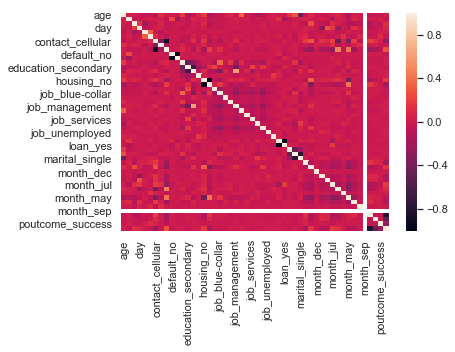

In [746]:
sns.heatmap(train.corr())

In [747]:
train.corr()['subscribe'].sort_values()

contact_unknown       -0.090645
housing_yes           -0.059530
marital_married       -0.058567
campaign              -0.047022
month_may             -0.044315
job_blue-collar       -0.034018
loan_yes              -0.031775
education_primary     -0.027882
month_jan             -0.027470
month_aug             -0.027198
month_jul             -0.022336
age                   -0.022015
education_secondary   -0.020028
poutcome_failure      -0.017549
month_nov             -0.015925
job_housemaid         -0.014918
day                   -0.014811
job_services          -0.014590
poutcome_unknown      -0.013740
job_entrepreneur      -0.007519
education_unknown     -0.007420
default_yes           -0.007160
poutcome_other        -0.001544
contact_telephone     -0.000882
job_technician        -0.000264
month_dec              0.000229
job_unknown            0.000599
month_jun              0.004402
job_self-employed      0.005054
default_no             0.007160
job_admin.             0.007819
job_unem

In [748]:
train.corr()['subscribe'].sort_values().index[:7]

Index(['contact_unknown', 'housing_yes', 'marital_married', 'campaign',
       'month_may', 'job_blue-collar', 'loan_yes'],
      dtype='object')

In [749]:
features = list(train.corr()['subscribe'].drop(index='month_sep').sort_values().index[-8:]) + \
    list(train.corr()['subscribe'].sort_values().index[:8])

In [750]:
features = list(features)

In [751]:
features

['housing_no',
 'contact_cellular',
 'month_oct',
 'month_apr',
 'poutcome_success',
 'month_mar',
 'duration',
 'subscribe',
 'contact_unknown',
 'housing_yes',
 'marital_married',
 'campaign',
 'month_may',
 'job_blue-collar',
 'loan_yes',
 'education_primary']

# SIBAL

In [752]:
train_len = len(train)
train = dataset[features][:train_len]
test = dataset[features][train_len:].drop(columns='subscribe')

In [753]:
# Separate train featrues and label

train['subscribe'] = train['subscribe'].astype('int')

Y_train = train['subscribe']

X_train = train.drop(columns='subscribe')

In [754]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


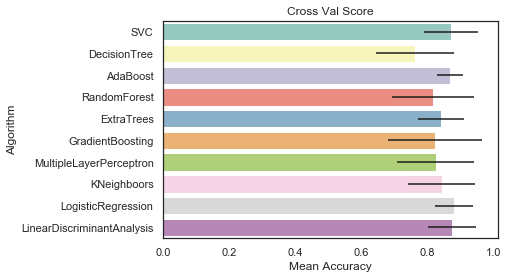

In [551]:
# Modeling step Test differents algorithms
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=\
                    random_state), random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy',\
                                     cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors":cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette='Set3',\
               orient='h',**{'xerr':cv_std})

g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross Val Score")

In [552]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.871649,0.081655,SVC
1,0.762084,0.117673,DecisionTree
2,0.868379,0.039118,AdaBoost
3,0.817236,0.123801,RandomForest
4,0.841978,0.069973,ExtraTrees
5,0.823344,0.141515,GradientBoosting
6,0.824316,0.117632,MultipleLayerPerceptron
7,0.843127,0.101598,KNeighboors
8,0.880288,0.056840,LogisticRegression
9,0.874588,0.073102,LinearDiscriminantAnalysis


In [471]:
# I choose use SVC model : 아니 왤케 잘해?
# + alpha Logistic regression : 혹시 모르니 하나 더 추가

In [553]:
Y_train.value_counts() / Y_train.count()

0    0.929871
1    0.070129
Name: subscribe, dtype: float64

### Hyperparameter Tuning for BEST model

In [236]:
# ### META MODELING WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# ### SVC classifier
# SVMC = SVC(probability=True)
# svc_param_grid = {'kernel':['rbf'], 'gamma':[0.001, 0.01, 0.1, 1],
#                   'C': [1, 10, 50, 100, 200, 300, 1000]}
# gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy',\
#                      n_jobs=4, verbose=1)

# gsSVMC.fit(X_train, Y_train)
# SVMC_best = gsSVMC.best_estimator_

# # BEST SCORE
# gvSVMC.best_score_

In [ ]:
# 일단 결과를 보려고 이렇게 하긴 했는데 이건 좀 별로다

In [628]:
SVMC = classifiers[0]
SVMC.fit(X_train, Y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

### Plot learning curves

In [629]:
# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
#                         n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
#     """Generate a simple plot of the test and training learning curve"""
#     plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")

#     plt.legend(loc="best")
#     return plt

# g = plot_learning_curve(SVMC,"SVC learning curves",X_train,Y_train,cv=kfold)

### Feature Importance

### Prediction

In [630]:
test_subscribe = pd.Series(np.where(SVMC.predict(test)==0,'no','yes'), name='subscribe')

In [631]:
test_subscribe.value_counts()

no     4514
yes     486
Name: subscribe, dtype: int64

In [632]:
results = pd.concat([index_series,test_subscribe], axis=1)
# results

In [633]:
results.to_csv('2_SVMC.csv',index=False)

### KNN

In [634]:
knnclf = KNeighborsClassifier()

In [635]:
knnclf.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [636]:
knnans = pd.Series(np.where(knnclf.predict(test)==0,'no','yes'), name='subscribe')

In [637]:
results = pd.concat([index_series,knnans], axis=1)
# results

In [638]:
knnans.value_counts()

no     4486
yes     514
Name: subscribe, dtype: int64

In [639]:
results.to_csv('2_knn.csv',index=False)

In [640]:
results.head()

,index,subscribe
0,40211,no
1,40212,no
2,40213,no
3,40214,no
4,40215,yes


### Speedy DL model

In [641]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train_scaled = MinMaxScaler().fit_transform(X_train)

model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(X_train_scaled.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [642]:
model.fit(X_train_scaled, Y_train, validation_split=0.2, verbose=1, epochs=20, batch_size=64)

Train on 31302 samples, validate on 7826 samples
Epoch 1/20
31302/31302 [==============================] - 6s 206us/step - loss: 0.2636 - acc: 0.9068 - val_loss: 0.3175 - val_acc: 0.8764
Epoch 2/20
31302/31302 [==============================] - 4s 127us/step - loss: 0.1606 - acc: 0.9422 - val_loss: 0.3152 - val_acc: 0.8835
Epoch 3/20
31302/31302 [==============================] - 4s 131us/step - loss: 0.1472 - acc: 0.9435 - val_loss: 0.2896 - val_acc: 0.8856
Epoch 4/20
31302/31302 [==============================] - 4s 130us/step - loss: 0.1414 - acc: 0.9451 - val_loss: 0.2825 - val_acc: 0.8899
Epoch 5/20
31302/31302 [==============================] - 4s 126us/step - loss: 0.1381 - acc: 0.9445 - val_loss: 0.2859 - val_acc: 0.8870
Epoch 6/20
31302/31302 [==============================] - 4s 129us/step - loss: 0.1360 - acc: 0.9456 - val_loss: 0.2882 - val_acc: 0.8826
Epoch 7/20
31302/31302 [==============================] - 4s 130us/step - loss: 0.1363 - acc: 0.9445 - val_loss: 0.2960 - v

In [643]:
test_scaled = MinMaxScaler().fit_transform(test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [644]:
np.where(model.predict(test_scaled)>0.5,1,0)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [645]:
tmp = pd.Series(np.where(model.predict(test_scaled).flatten()>0.5,'yes','no'), name='subscribe')

In [646]:
tmp.value_counts()

no     4126
yes     874
Name: subscribe, dtype: int64

In [647]:
results = pd.concat([index_series,tmp], axis=1)

results.head()

,index,subscribe
0,40211,no
1,40212,no
2,40213,no
3,40214,no
4,40215,yes


In [648]:
results.to_csv('2_DNN.csv',index=False)
# 56퍼센트

### XGB

In [649]:
import xgboost as xgb

xgbclf = xgb.XGBClassifier()
xgbclf.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [650]:
xgbclf.predict(test)

array([0, 0, 0, ..., 1, 0, 0])

In [651]:
xgbans = pd.Series(np.where(xgbclf.predict(test)==0,'no','yes'), name='subscribe')
results = pd.concat([index_series,xgbans], axis=1)
# results

In [652]:
xgbans.value_counts()

no     3957
yes    1043
Name: subscribe, dtype: int64

In [653]:
results.to_csv('2_xgb.csv',index=False)
# 56퍼센트

### Logistic

In [755]:
lgclf = LogisticRegression()
lgclf.fit(X_train, Y_train)
tmp = pd.Series(np.where(lgclf.predict(test)>0.5,'yes','no'), name='subscribe')

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [756]:
results = pd.concat([index_series,xgbans], axis=1)

In [757]:
results.to_csv('2_logistic.csv',index=False)